In [129]:
import torch
from scipy.io import loadmat
import matplotlib.pyplot as plt
from models import *
torch.set_default_tensor_type(torch.DoubleTensor)

In [130]:
data = loadmat('Coursework2_Problem_1/plate_data.mat')

In [131]:
L_boundary = torch.tensor(data['L_boundary'], dtype=torch.float64)
R_boundary = torch.tensor(data['R_boundary'], dtype=torch.float64)
T_boundary = torch.tensor(data['T_boundary'], dtype=torch.float64)
B_boundary = torch.tensor(data['B_boundary'], dtype=torch.float64)
C_boundary = torch.tensor(data['C_boundary'], dtype=torch.float64)
Boundary   = torch.tensor(data['Boundary'], dtype=torch.float64, requires_grad=True)

# truth solution from FEM
disp_truth = torch.tensor(data['disp_data'], dtype=torch.float64)

# connectivity matrix - this helps you to plot the figure but we do not need it for PINN
t_connect  = torch.tensor(data['t'].astype(float), dtype=torch.float64)

# all collocation points
x_full = torch.tensor(data['p_full'], dtype=torch.float64,requires_grad=True)

# collocation points excluding the boundary
x = torch.tensor(data['p'], dtype=torch.float64, requires_grad=True)


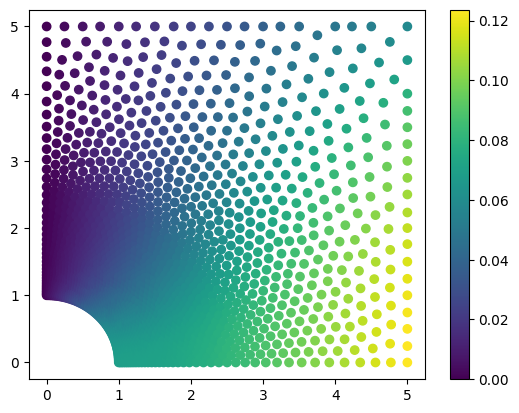

In [147]:
plt.scatter(x_full[:,0].detach().numpy(), x_full[:,1].detach().numpy(), c=disp_truth[:,0].detach().numpy(), cmap='viridis')
# plt.scatter(C_boundary[:,0].detach().numpy(), C_boundary[:,1].detach().numpy(), c='r')
plt.colorbar()
# plt.show()

In [133]:
Disp_layer = [2, 400, 400, 400, 2] # Architecture of displacement net - you may change as you wish
Stress_layer = [2,400,400, 400 ,3] # Architecture of stress net - you may change as you wish

stress_net = DenseNet(Stress_layer,nn.Tanh) # Note we choose hyperbolic tangent as an activation function here
disp_net =  DenseNet(Disp_layer,nn.Tanh)

# Define material properties
E = 10 #N/m^2
mu = 0.3

stiff = E/(1-mu**2)*torch.tensor([[1,mu,0],[mu,1,0],[0,0,(1-mu)/2]]) # Hooke's law for plane stress
stiff = stiff.unsqueeze(0)

In [ ]:
# PINN requires super large number of iterations to converge (on the order of 50e^3-100e^3)
iterations = 2500
# Define loss function
loss_func = torch.nn.MSELoss()

# Broadcast stiffness for batch multiplication later
stiff_bc = stiff
stiff = torch.broadcast_to(stiff, (len(x),3,3))

stiff_bc = torch.broadcast_to(stiff_bc, (len(Boundary),3,3))

params = list(stress_net.parameters()) + list(disp_net.parameters())

# Define optimizer and scheduler
optimizer = torch.optim.Adam(params, lr=2e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

rand_index = torch.randint(0, len(x_full), (len(x_full),))
disp_fix = disp_truth[rand_index,:]

In [145]:
disp_fix.shape

torch.Size([1965, 2])

In [ ]:
for epoch in range(250):
    # scheduler.step()
    optimizer.zero_grad()

    # To compute stress from stress net
    sigma = stress_net(x)
    # To compute displacement from disp net
    disp = disp_net(x)

    # displacement in x direction
    u = disp[:,0]
    # displacement in y direction
    v = disp[:,1]

    # find the derivatives
    dudx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),create_graph=True)[0]
    dvdx = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(u),create_graph=True)[0]

    # Define strain
    e_11 = dudx[:,0].unsqueeze(1)
    e_22 = dvdx[:,1].unsqueeze(1)
    e_12 = 0.5 * (dvdx[:,0].unsqueeze(1) + dudx[:,1].unsqueeze(1))  

    e = torch.cat((e_11,e_22,e_12), 1)
    e = e.unsqueeze(2)

    # Define augment stress
    sig_aug = torch.bmm(stiff, e).squeeze(2)

    # Define constitutive loss - forcing the augment stress to be equal to the neural network stress
    loss_cons = loss_func(sig_aug, sigma)

    # find displacement and stress at the boundaries
    disp_bc = disp_net(Boundary)
    sigma_bc = stress_net(Boundary)
    u_bc = disp_bc[:,0]
    v_bc = disp_bc[:,1]

    # Compute the strain and stresses at the boundary
    dudx_bc = torch.autograd.grad(u_bc, Boundary, grad_outputs=torch.ones_like(u_bc),create_graph=True)[0]
    dvdx_bc = torch.autograd.grad(v_bc, Boundary, grad_outputs=torch.ones_like(u_bc),create_graph=True)[0]

    e_11_bc = dudx_bc[:,0].unsqueeze(1)
    e_22_bc = dvdx_bc[:,1].unsqueeze(1)
    e_12_bc = 0.5* (dudx_bc[:,1].unsqueeze(1) + dvdx_bc[:,0].unsqueeze(1))

    e_bc = torch.cat((e_11_bc,e_22_bc,e_12_bc), 1)
    e_bc = e_bc.unsqueeze(2)

    sig_aug_bc = torch.bmm(stiff_bc, e_bc).squeeze(2)

    # force the augment stress to agree with the NN stress at the boundary
    loss_cons_bc = loss_func(sig_aug_bc, sigma_bc)

    #============= equilibrium ===================#

    sig_11 = sigma[:,0]
    sig_22 = sigma[:,1]
    sig_12 = sigma[:,2]

    # stress equilibrium in x and y direction
    dsig11dx = torch.autograd.grad(sig_11, x, grad_outputs=torch.ones_like(sig_11),create_graph=True)[0]
    dsig22dx = torch.autograd.grad(sig_22, x, grad_outputs=torch.ones_like(sig_22),create_graph=True)[0]
    dsig12dx = torch.autograd.grad(sig_12, x, grad_outputs=torch.ones_like(sig_12),create_graph=True)[0]

    eq_x1 = dsig11dx[:,0]+dsig12dx[:,1]
    eq_x2 = dsig22dx[:,1]+dsig12dx[:,0]

    # zero body forces
    f_x1 = torch.zeros_like(eq_x1)
    f_x2 = torch.zeros_like(eq_x2)

    loss_eq1 = loss_func(eq_x1, f_x1)
    loss_eq2 = loss_func(eq_x2, f_x2)
    #========= boundary ========================#

    # specify the boundary condition
    tau_R = 0.1 # N/m^2 # torch.zeros_like(R_boundary[:,0]) # NOTE: make sure the dimension is correct
    tau_T = 0 # torch.zeros_like(T_boundary[:,1]) 
    #
    u_L= disp_net(L_boundary)
    u_B = disp_net(B_boundary)

    sig_R = stress_net(R_boundary)
    sig_T = stress_net(T_boundary)
    sig_C = stress_net(C_boundary)

    # Symmetry boundary condition left
    loss_BC_L = loss_func(u_L[:,0], torch.zeros_like(u_L[:,0]))
    # Symmetry boundary condition bottom
    loss_BC_B = loss_func(u_B[:, 1], torch.zeros_like(u_B[:, 1]))
    # Force boundary condition right
    loss_BC_R = loss_func(sig_R[:, 0], tau_R*torch.ones_like(sig_R[:, 0])) \
                + loss_func(sig_R[:, 2],  torch.zeros_like(sig_R[:, 2]))

    loss_BC_T = + loss_func(sig_T[:, 1], tau_T*torch.ones_like(sig_T[:, 1]))   \
                + loss_func(sig_T[:, 2],  torch.zeros_like(sig_T[:, 2]))

    # traction free on circle
    loss_BC_C = loss_func(sig_C[:,0]*C_boundary[:,0]+sig_C[:,2]*C_boundary[:,1], torch.zeros_like(sig_C[:, 0]))  \
                + loss_func(sig_C[:,2]*C_boundary[:,0]+sig_C[:,1]*C_boundary[:,1], torch.zeros_like(sig_C[:, 0]))

    # Define loss function:
    loss = loss_eq1+loss_eq2+loss_cons+loss_BC_L+loss_BC_B+loss_BC_R+loss_BC_T+loss_BC_C+loss_cons_bc


    # ======= uncomment below for part (e) =======================
    # data_loss_fix
    x_fix = x_full[rand_index, :]
    u_fix = disp_net(x_fix)
    loss_fix = loss_func(u_fix,disp_fix)
    loss = loss_eq1+loss_eq2+loss_cons+loss_BC_L+loss_BC_B+loss_BC_R+loss_BC_T+loss_BC_C+loss_cons_bc + 100*loss_fix


    loss.backward()
    print('loss', loss, 'iter', epoch)
    optimizer.step()



loss tensor(1.4809, grad_fn=<AddBackward0>) iter 0
loss tensor(0.5428, grad_fn=<AddBackward0>) iter 1
loss tensor(0.7125, grad_fn=<AddBackward0>) iter 2
loss tensor(0.4378, grad_fn=<AddBackward0>) iter 3
loss tensor(0.2584, grad_fn=<AddBackward0>) iter 4
loss tensor(0.3217, grad_fn=<AddBackward0>) iter 5
loss tensor(0.3578, grad_fn=<AddBackward0>) iter 6
loss tensor(0.2701, grad_fn=<AddBackward0>) iter 7
loss tensor(0.2024, grad_fn=<AddBackward0>) iter 8
loss tensor(0.2204, grad_fn=<AddBackward0>) iter 9
loss tensor(0.2393, grad_fn=<AddBackward0>) iter 10
loss tensor(0.1945, grad_fn=<AddBackward0>) iter 11
loss tensor(0.1257, grad_fn=<AddBackward0>) iter 12
loss tensor(0.0950, grad_fn=<AddBackward0>) iter 13
loss tensor(0.1104, grad_fn=<AddBackward0>) iter 14
loss tensor(0.1278, grad_fn=<AddBackward0>) iter 15
loss tensor(0.1103, grad_fn=<AddBackward0>) iter 16
loss tensor(0.0737, grad_fn=<AddBackward0>) iter 17
loss tensor(0.0607, grad_fn=<AddBackward0>) iter 18
loss tensor(0.0804, gr

In [139]:
# stress_est = stress_net(x_full)
# plt.scatter(x_full[:,0].detach().numpy(), x_full[:,1].detach().numpy(), c=stress_est[:,0].detach().numpy(), cmap='jet')
# plt.colorbar()

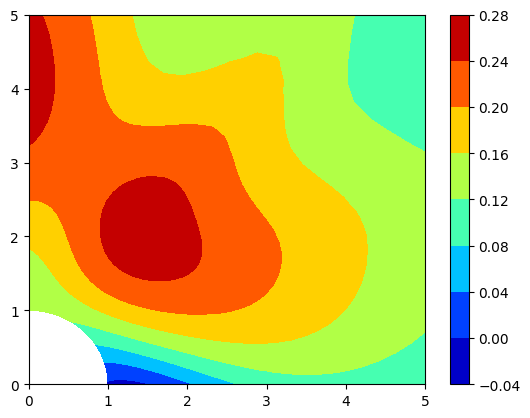

In [144]:
# Plot the stress
import matplotlib.tri as mtri

stiff = E / (1 - mu ** 2) * torch.tensor([[1, mu, 0], [mu, 1, 0], [0, 0, (1 - mu) / 2]])
stiff = stiff.unsqueeze(0)

stiff_bc = stiff
stiff_full = stiff
stiff = torch.broadcast_to(stiff, (len(x), 3, 3))

stiff_bc = torch.broadcast_to(stiff_bc, (len(Boundary), 3, 3))
stiff_full = torch.broadcast_to(stiff_full, (len(x_full), 3, 3))

u_full = disp_net(x_full)
stress_full = stress_net(x_full)

xx = x_full[:,0].detach().numpy()
yy = x_full[:,1].detach().numpy()
sig11 = stress_full[:,1].detach().numpy()

connect =(t_connect -1).detach().numpy()

triang = mtri.Triangulation(xx, yy, connect)

u_11 = u_full[:,0].detach().numpy()

u = u_full[:, 0]
v = u_full[:, 1]

dudx = torch.autograd.grad(u, x_full, grad_outputs=torch.ones_like(u), create_graph=True)[0]
dvdx = torch.autograd.grad(v, x_full, grad_outputs=torch.ones_like(v), create_graph=True)[0]

e_11 = dudx[:, 0].unsqueeze(1)
e_22 = dvdx[:, 1].unsqueeze(1)
e_12 = 0.5 * (dudx[:, 1] + dvdx[:, 0]).unsqueeze(1)

e = torch.cat((e_11, e_22, e_12), 1)
e = e.unsqueeze(2)

sigma = torch.bmm(stiff_full, e).squeeze(2)

plt.figure(2)
plt.clf()
plt.tricontourf(triang,sigma[:,0].detach().numpy(), cmap = 'jet')
plt.colorbar()
plt.show()